# Creating Brats Datasets

In [2]:
import os
import time
import tensorflow as tf
import torch
import torchvision
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nibabel as nib
import random
from scipy import stats
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from typing import List, Set

print(tf.__version__)

# Setting plot styles
sns.set_style('white')
mpl.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'figure.figsize': (6, 6 / 1.61)
})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4)
})

# Only use CPU
# gpus = tf.config.experimental.set_visible_devices([], 'GPU')

# Use GPU and only use the memory we need
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
K = keras.backend
np.set_printoptions(suppress=True)

mood_brain_dir = '/data/mood/brain/brain_train'
mood_brain_mask_dir = '/data/mood/brain/toy_label/pixel'
mood_brain_toy_dir = '/data/mood/brain/toy'
mood_brain_toy_flipLR_dir = '/home/derek/toy_flipLR'
mood_brain_flipLR_dir = '/data/mood/brain/brain_train_reflreg'

mood_abdom_dir = '/data/mood/abdom/abdom_train'
mood_abdom_mask_dir = '/data/mood/abdom/toy_label/pixel'
mood_abdom_toy_dir = '/data/mood/abdom/toy'

2.11.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Helper Functions

In [3]:
def min_max_normalization(x, low=0, high=1, axis=None):
    return low + (x - np.min(x, axis=axis)) * (high - low) / (np.max(x, axis=axis) - np.min(x, axis=axis))

def bits_per_dim(y_true, y_pred, nr_mix, batch_size=1):
    """Convert the loss to bits per dim"""
    dims = y_true.shape
    loss = nn.grayscale_mix_loss(y_true, y_pred, nr_mix)
    loss /= (np.log(2.) * np.prod(dims) * batch_size)
    return loss

# Faster inference with graph mode
@tf.function
def inference_step(x, model, nr_mix, loss_fn, h=None, per_pixel=False, sum_all=False):
    out = model(x, h, training=False)
    l = loss_fn(x, out, nr_mix, per_pixel=per_pixel, sum_all=sum_all)
    return l
    
def evaluate(x, model, nr_mix=10, h=None, batch_size=64, per_pixel=False, sum_all=False, loss_fn='discrete'):
    """Return the the log-likelihood over a given dataset of patches"""
    
    if loss_fn == 'discrete':
        loss_fn = nn.grayscale_mix_loss
    elif loss_fn == 'continuous':
        loss_fn = nn.continuous_grayscale_mix_loss
    else:
        raise AssertionError
        
    autotune = tf.data.experimental.AUTOTUNE
    dset = tf.data.Dataset.from_tensor_slices((x, h)).batch(batch_size).prefetch(autotune)
    pbar = tqdm(dset, total=int(np.ceil(x.shape[0]/batch_size)))
    
    res = []
    for batch_X, batch_h, in pbar:
        l = -inference_step(batch_X, model, nr_mix, loss_fn, batch_h, per_pixel, sum_all)
        res.append(l)
    return tf.concat(res, 0)

def z_score_normalize(img, tol=0, ddof=1):
    """
    Normalizes the image by subtracting the mean and dividing by
    the standard deviation over the nonzero elements
    
    NOTE: Current results don't use this preprocessing
    """
    # need a tolerance value for CT scans, bg is nonzero
    mask = (img > tol)
    num_non_zero = np.count_nonzero(mask)
    mean = np.sum(img * mask) / num_non_zero
    
    # Mask the means, will only take into account non-background values
    mask = mask * mean
    
    # std deviation without zeros
    std = (np.sum((img - mask)**2) / (num_non_zero - ddof))**(1/2)
    
    # z-score normalization of the image
    scaled_img = (img - mean) / std
    thres = (tol - mean) / std
    
    return scaled_img, thres

In [4]:
# Code for extracting patches from the images
def crop_background(img, tol=0):
    """Doesn't really work for CT images, a lot of axes have non background voxels"""
    if img.shape[0] == 512:
        return img
    mask = img > tol
    if img.ndim == 3:
        x_any = mask.any((1, 2))
        y_any = mask.any((0, 2))
        z_any = mask.any((0, 1))
        
        # Getting the index of first and last nonzero elements along dimension of the image
        x_start, x_end = np.argmax(x_any), mask.shape[0] - np.argmax(x_any[::-1])
        y_start, y_end = np.argmax(y_any), mask.shape[1] - np.argmax(y_any[::-1])
        z_start, z_end = np.argmax(z_any), mask.shape[1] - np.argmax(z_any[::-1])
        return img[x_start:x_end, y_start:y_end, z_start:z_end]
    else:
        x_any = mask.any(1)
        y_any = mask.any(0)
        
        x_start, x_end = np.argmax(x_any), mask.shape[0] - np.argmax(x_any[::-1])
        y_start, y_end = np.argmax(y_any), mask.shape[1] - np.argmax(y_any[::-1])
        return img[x_start:x_end, y_start:y_end]

def train_test_split_filenames(dir_or_arr, num_img=None, test_size=0, seed=None, shuffle=True):
    """Creating a train/test split for the file paths of each image"""
    if isinstance(dir_or_arr, str):
        filenames = [os.path.join(dir_or_arr, fn) for fn in os.scandir(dir_or_arr)]
    else:
        filenames = dir_or_arr
    
    if not num_img:
        num_img = len(filenames)
        
    if isinstance(test_size, float):
        train_size = num_img - np.ceil(num_img * test_size).astype(int)
    elif isinstance(test_size, int):
        train_size = num_img - test_size
    else:
        raise TypeError
    
    if shuffle:
        rng = np.random.default_rng(seed=seed)
        rng.shuffle(filenames)
        
    train_paths = filenames[:train_size]
    test_paths = filenames[train_size: num_img]
    
    return train_paths, test_paths
    
def image_generator(img_paths, tol=0):
    """Loads numpy arrays of images from disk"""
    for path in img_paths:
        img = nib.load(path)
        img_data = img.get_fdata()
        yield img_data, tol
        
def change_anatomical_view(img, plane):
    if plane == 'axial':
        return img
    elif plane == 'sagittal':
        return np.moveaxis(img, [0, 1, 2], [2, 0, 1])
    elif plane == 'coronal':
        return np.moveaxis(img, [0, 1, 2], [0, 2, 1])
    else:
        raise TypeError

        
def semantic_patch_sampler(
    data, patchdim, npatches, tol=0, seed=None, anom_mask=False, num_channels=1, bg_tol=None, plane='axial', no_anom=False):
    """Randomly sampling patches from a single image
    Generalize for case of using the sampler with a mask to only select
    non anomalous patches
    """
    # Define threshold to exclude background voxels, tol for CT should be nonzero 
    data = change_anatomical_view(data, plane)
    
    if anom_mask is not False:
        anom_mask = change_anatomical_view(anom_mask, plane)
        
    curr_num = 0
    half_dim = patchdim // 2
    rem = int(patchdim % 2)
    patchset = np.empty((npatches, patchdim, patchdim, num_channels))
    rng = np.random.default_rng(seed)
    num_pixels = patchdim**2*num_channels
    
    #if anom_mask is not False:
    #    # Check if is sample wise anomaly
    #    is_slices_anom = (anom_mask != 0).any(axis=(0, 1)) # checking for presence of anom per slice
    #    if is_slices_anom.any():
    #        # Take only slices that are anomalous
    #        data = data[:, :, is_slices_anom]
    #        anom_mask = anom_mask[:, :, is_slices_anom]
    #    else:
    #        anom_mask = False
    
    while curr_num < npatches:
        found = False
        while not found:
            x = rng.integers(half_dim, (data.shape[0] - 1) - (half_dim + 1) + 2)
            y = rng.integers(half_dim, (data.shape[1] - 1) - (half_dim + 1) + 2)
            
            # Offsetting start and end intervals by num_channels to avoid out of index error when slicing
            z = rng.integers(num_channels - 1, data.shape[2]- num_channels)
            z0 = z
            z1 = z + num_channels
            
            
            patch = data[(x - half_dim + 1): (x + half_dim + 1 + rem), (y - half_dim + 1): (y + half_dim + 1 + rem), z0:z1]
            if anom_mask is not False:
                mask_patch = anom_mask[(x - half_dim + 1): (x + half_dim + 1 + rem), (y - half_dim + 1): (y + half_dim + 1 + rem), z0:z1]
            
            # Do not want background values
            sel_crit = np.count_nonzero(patch > tol) == num_pixels if not bg_tol else np.count_nonzero(patch > tol) < int(bg_tol * num_pixels)
            if sel_crit and anom_mask is False:
                found = True
                patchset[curr_num] = patch
                curr_num += 1
            # Do not want background values
            elif np.count_nonzero(patch > tol) == num_pixels and anom_mask is not False:
                if no_anom:
                    if np.count_nonzero(mask_patch) == 0:
                        found = True
                        patchset[curr_num] = patch
                        curr_num += 1
                elif np.count_nonzero(mask_patch) > int(num_pixels * 0.1):
                    found = True
                    patchset[curr_num] = patch
                    curr_num += 1
    return patchset


def make_patch_dataset(
    img_paths, patchdim, num_patches, tol=0, seed=None, mask_paths=None, 
    num_channels=1, bg_tol=None, plane='axial', flip_labels=False):
    """Creating a dataset of patches from an array of image file paths"""
    dset = []
    img_gen = image_generator(img_paths, tol=tol)
    num_img = len(img_paths)
    npatches_per_img = num_patches // num_img
    rem = num_patches % num_img
    
    anom_mask = False
    
    if mask_paths:
        mask_gen = image_generator(mask_paths)
    
    # Sample the number of patches per brain given dataset size plus remainder 
    # from evenly divided number of patches for the first brain
    if rem != 0:
        img, thres = next(img_gen)
        
        if mask_paths:
            anom_mask, _ = next(mask_gen)
            
            if flip_labels:
                anom_mask = anom_mask == 0 
            
        patches = semantic_patch_sampler(
            img, patchdim, npatches_per_img + rem, thres, 
            seed=seed, anom_mask=anom_mask, num_channels=num_channels, bg_tol=bg_tol, plane=plane, no_anom=flip_labels)
        dset.append(patches)
        num_img -= 1
    
    for img, thres in tqdm(img_gen, total=num_img, position=0, leave=True):
        if mask_paths:
            anom_mask, _ = next(mask_gen)
        patches = semantic_patch_sampler(
            img, patchdim, npatches_per_img, thres, seed=seed, anom_mask=anom_mask,
            num_channels=num_channels, bg_tol=bg_tol, plane=plane, no_anom=flip_labels)
        dset.append(patches)
        
    dset = np.vstack(dset) 
    return dset


def reflective_patch_sampler(data, ref_data, patchdim, npatches, tol=0, seed=None, anom_mask=False, bg_tol=None):
    """Randomly sampling patches from a single image and its reflection"""
    # Define threshold to exclude background voxels, tol for CT should be nonzero 
    curr_num = 0
    num_channels = 2
    half_dim = patchdim // 2
    rem = int(patchdim % 2)
    patchset = np.empty((npatches, patchdim, patchdim, num_channels))
    rng = np.random.default_rng(seed)
    num_pixels = patchdim**2
    
    if anom_mask is not False:
        # Check if is sample wise anomaly
        is_slices_anom = (anom_mask == 1).any(axis=(0, 1)) # checking for presence of anom per slice
        
        if is_slices_anom.any():
            # Take only slices that are anomalous
            data = data[:, :, is_slices_anom]
            ref_data = ref_data[:, :, is_slices_anom]
            anom_mask = anom_mask[:, :, is_slices_anom]
        else:
            anom_mask = False
    
    while curr_num < npatches:
        found = False
        while not found:
            x = rng.integers(half_dim, (data.shape[0] - 1) - (half_dim + 1) + 2)
            y = rng.integers(half_dim, (data.shape[1] - 1) - (half_dim + 1) + 2)
            z = rng.integers(0, data.shape[2])
            
            x1 = (x - half_dim + 1)
            x2 = (x + half_dim + 1 + rem)
            y1 = (y - half_dim + 1)
            y2 = (y + half_dim + 1 + rem)
            patch = data[x1:x2 , y1:y2 , z]
            ref_patch = ref_data[x1:x2 , y1:y2 , z]
            
            if anom_mask is not False:
                mask_patch = anom_mask[x1:x2 , y1:y2 , z]
            
            # Do not want background values
            sel_crit = np.count_nonzero(patch > tol) == num_pixels if not bg_tol else np.count_nonzero(patch > tol) > (num_pixels - int(bg_tol * num_pixels)) 
            if sel_crit and anom_mask is False:
                found = True
                patchset[curr_num] = np.stack([patch, ref_patch], -1)
                curr_num += 1
            # Do not want background values
            elif sel_crit and anom_mask is not False:
                if np.count_nonzero(mask_patch) > int(num_pixels * 0.1):
                    found = True
                    patchset[curr_num] = np.stack([patch, ref_patch], -1)
                    curr_num += 1
    return patchset


def make_reflective_patch_dataset(
    img_paths, patchdim, num_patches, tol=0, seed=None, mask_paths=None, num_channels=1, bg_tol=None):
    """Creating a dataset of patches from an array of image file paths"""
    dset = []
    
    normal_img_paths = []
    ref_img_paths = []
    
    for paths in img_paths:
        normal_img_paths.append(paths[0])
        ref_img_paths.append(paths[1])
        
    img_gen = image_generator(normal_img_paths, tol=tol)
    ref_img_gen = image_generator(ref_img_paths, tol=tol)
    
    num_img = len(img_paths)
    npatches_per_img = num_patches // num_img
    rem = num_patches % num_img
    
    anom_mask = False
    
    if mask_paths:
        mask_gen = image_generator(mask_paths)
    
    # Sample the number of patches per brain given dataset size plus remainder 
    # from evenly divided number of patches for the first brain
    if rem != 0:
        img, thres = next(img_gen)
        ref_img, thres = next(ref_img_gen)
        
        if mask_paths:
            anom_mask, _ = next(mask_gen)
            
        patches = reflective_patch_sampler(img, ref_img, patchdim, npatches_per_img + rem, thres, anom_mask=anom_mask, bg_tol=bg_tol)
        dset.append(patches)
        num_img -= 1
    
    for (img, _), (ref_img, thres) in tqdm(zip(img_gen, ref_img_gen), total=num_img, position=0, leave=True):
        if mask_paths:
            anom_mask, _ = next(mask_gen)
        patches = reflective_patch_sampler(img, ref_img, patchdim, npatches_per_img, thres, anom_mask=anom_mask, bg_tol=bg_tol)
        dset.append(patches)
        
    dset = np.vstack(dset) 
    return dset

In [5]:
# Sampling slices
def semantic_slice_sampler(data, slicedim, nslices, tol=0, seed=None):
    """Randomly sampling axial slices from a single image"""
    # Define threshold to exclude background voxels, tol for CT should be nonzero 
    curr_num = 0
    sliceset = np.empty((nslices, slicedim, slicedim))
    rng = np.random.default_rng(seed)
    
    while curr_num < nslices:
        found = False
        while not found:
            z = rng.integers(0, data.shape[2]-1)
            axial_slice = data[:, :, z, np.newaxis]
            
            # Only want slices with some semantic voxels
            if np.count_nonzero(axial_slice > 0) > 0:
                found = True
                axial_slice = tf.squeeze(tf.image.resize(axial_slice, (slicedim, slicedim)))
                sliceset[curr_num] = axial_slice
                curr_num += 1
    return sliceset

def make_slice_dataset(img_paths, slicedim, num_slices, tol=0, seed=None):
    """Creating a dataset of slices from an array of image file paths"""
    dset = []
    img_gen = image_generator(img_paths, tol=tol)
    num_img = len(img_paths)
    nslices_per_img = num_slices // num_img
    rem = num_slices % num_img
    
    if rem != 0:
        img, thres = next(img_gen)
        slices = semantic_slice_sampler(img, slicedim, nslices_per_img + rem, thres, seed=seed)
        dset.append(slices)
        num_img -= 1
    
    for img, thres in tqdm(img_gen, total=num_img):
        slices = semantic_slice_sampler(img, slicedim, nslices_per_img, thres, seed=seed)
        dset.append(slices)
        
    dset = np.vstack(dset) 
    return dset

def get_nifti(dirname: str, key_words: Set[str] = {}) -> List[str]:
    """
    Return a list of relative file paths to nifti images from the passed
    directory.

    dirname can be relative or absolute.
    """
    walk = os.walk(dirname)
    img_paths = []
    valid_file_types = {'.nii', '.nii.gz'}

    for root, dirs, files in walk:
        for f in files:
            has_kw = all(key_word in f for key_word in key_words)
            
            if (f.endswith('.nii') or f.endswith('.nii.gz')) and has_kw:
                img_paths.append(os.path.join(root, f))
                
    return img_paths

def make_strided_patches(
    img, patch_size=(28, 28), stride=(4, 4), tol=0.1, bg_tol=0., preprocess=None, seg_mask=None, anom_tol=0):
    """
    Returns a tuple of patches and coordinates given the a 2D slice of an image an optional 
    patch size and the stride length parameters.
    """
    # For our case of medical images, we discard images that are purely background
    if (img == 0).all():
        return None
    
    patches = []
    coords = []
    
    x_stride = stride[0]
    y_stride = stride[1]
    
    x_max = img.shape[0]
    y_max = img.shape[1]
    
    n_xstrides = (x_max - patch_size[0]) // x_stride
    n_ystrides = (y_max - patch_size[1]) // y_stride
    for x_stride_num in range(n_xstrides + 1):
        x_cur = x_stride_num * x_stride
        for y_stride_num in range(n_ystrides + 1):
            y_cur = y_stride_num * y_stride
            y2 = y_cur + patch_size[1]
            
            x2 = x_cur + patch_size[0]
            patch = img[x_cur : x2, y_cur: y2]
            
            if seg_mask is not None:
                seg_patch = seg_mask[x_cur : x2, y_cur: y2]
                #print((seg_patch != 0).sum())
                anom_thresh = (seg_patch != 0).sum() <= int(anom_tol * patch_size[0] * patch_size[1])
            else:
                anom_thresh = True
                
            if (patch <= bg_tol).sum() <= int(patch_size[0] * patch_size[0] * tol) and anom_thresh:
                if preprocess is not None:
                    patches.append(preprocess(patch))
                else:
                    patches.append(patch)
                coords.append([x_cur, x2, y_cur, y2])
            
    #if patches == []:
    #    return None
    
    #patches = torch.cat(patches).view(-1, 1, patch_size[0], patch_size[1])
    #coords = torch.tensor(coords)
    patches = np.c_[patches]
    print(patches.shape)
    coords = np.array(coords)
    return patches, coords

### BraTS 2018

In [5]:
brats_img = '/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii'
brats_seg = '/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii'
img = nib.load(brats_img).get_fdata()
seg_img = nib.load(brats_seg).get_fdata()

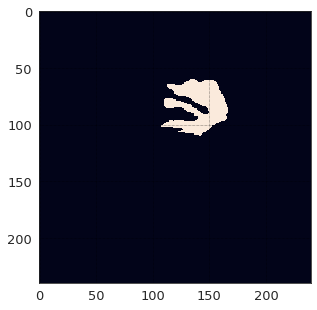

In [41]:
plt.imshow(seg_img[:, :, 89])

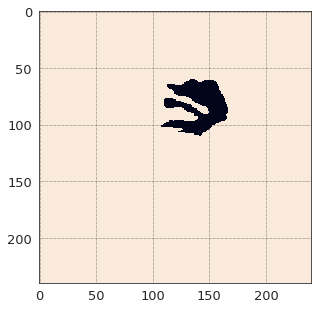

In [44]:
plt.imshow((seg_img == 0)[:, :, 89])

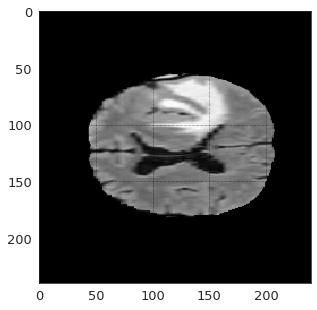

In [14]:
plt.imshow(img[:, :, 89], cmap='gray')

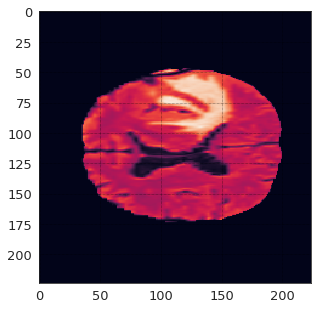

In [38]:
cropped = tf.image.central_crop(np.expand_dims(img[:, :, 89], -1), 224/240)
plt.imshow(np.squeeze(cropped))

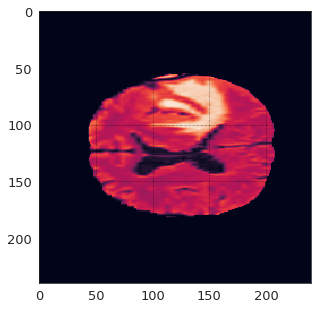

In [40]:
plt.imshow(img[:, :, 89])

In [5]:
# Extracting file names from training folder
dirname = '/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/'
brats_2018_paths = get_nifti(dirname, key_words={'flair'})
brats_2018_seg_paths = get_nifti(dirname, key_words={'seg'})

train_fn, val_fn = train_test_split_filenames(
    brats_2018_paths, test_size=0.1, shuffle=True, seed=11)
seg_train_fn, seg_val_fn = train_test_split_filenames(
    brats_2018_seg_paths, test_size=0.1, shuffle=True, seed=11)

### Brats Patches

In [16]:
train_subvolume_dataset = []
for img_path, seg_path in zip(train_fn, seg_train_fn):
    img = nib.load(img_path).get_fdata()
    
    img = img / img.max()
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    print(img_path)
    for s in range(subvolume.shape[-1]):
        crop_img = tf.image.central_crop(np.expand_dims(subvolume[:, :, s], -1), 224/subvolume.shape[0]).numpy()
        crop_seg = tf.image.central_crop(np.expand_dims(seg_subvolume[:, :, s], -1), 224/seg_subvolume.shape[0]).numpy()
        patches, _ = make_strided_patches(
            crop_img,
            tol=0.1,
            stride=(7, 7),
            seg_mask=crop_seg,
            anom_tol=0
        )
        train_subvolume_dataset.append(patches)
        
train_subvolume_np = np.concatenate(train_subvolume_dataset, 0)

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA13_624_1/Brats18_TCIA13_624_1_flair.nii
(162, 28, 28, 1)
(164, 28, 28, 1)
(163, 28, 28, 1)
(168, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQD_1/Brats18_CBICA_AQD_1_flair.nii
(141, 28, 28, 1)
(143, 28, 28, 1)
(143, 28, 28, 1)
(144, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_491_1/Brats18_TCIA02_491_1_flair.nii
(109, 28, 28, 1)
(108, 28, 28, 1)
(106, 28, 28, 1)
(110, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA08_113_1/Brats18_TCIA08_113_1_flair.nii
(112, 28, 28, 1)
(111, 28, 28, 1)
(111, 28, 28, 1)
(107, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_640_1/Brats18_TCIA10_640_1_flair.nii
(224, 28, 28, 1)
(220, 28, 28, 1)
(200, 28, 28, 1)
(195, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AVG_1/Brats18_CBICA_AVG_1_flair.nii
(233, 28, 28, 1)
(231, 28, 28, 1)
(229, 

(23, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ABB_1/Brats18_CBICA_ABB_1_flair.nii
(202, 28, 28, 1)
(199, 28, 28, 1)
(195, 28, 28, 1)
(193, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_231_1/Brats18_TCIA01_231_1_flair.nii
(125, 28, 28, 1)
(124, 28, 28, 1)
(124, 28, 28, 1)
(123, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_235_1/Brats18_TCIA01_235_1_flair.nii
(233, 28, 28, 1)
(232, 28, 28, 1)
(228, 28, 28, 1)
(222, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA06_184_1/Brats18_TCIA06_184_1_flair.nii
(146, 28, 28, 1)
(147, 28, 28, 1)
(146, 28, 28, 1)
(152, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AUN_1/Brats18_CBICA_AUN_1_flair.nii
(98, 28, 28, 1)
(99, 28, 28, 1)
(93, 28, 28, 1)
(93, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA08_280_1/Brats18_TCIA08_280_1_flair.nii
(232, 28, 28, 1)
(231, 28, 2

(130, 28, 28, 1)
(127, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ATF_1/Brats18_CBICA_ATF_1_flair.nii
(173, 28, 28, 1)
(178, 28, 28, 1)
(195, 28, 28, 1)
(181, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_0_1/Brats18_2013_0_1_flair.nii
(144, 28, 28, 1)
(140, 28, 28, 1)
(140, 28, 28, 1)
(138, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_335_1/Brats18_TCIA01_335_1_flair.nii
(171, 28, 28, 1)
(172, 28, 28, 1)
(171, 28, 28, 1)
(168, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_321_1/Brats18_TCIA02_321_1_flair.nii
(126, 28, 28, 1)
(124, 28, 28, 1)
(122, 28, 28, 1)
(128, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AOD_1/Brats18_CBICA_AOD_1_flair.nii
(172, 28, 28, 1)
(170, 28, 28, 1)
(176, 28, 28, 1)
(176, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA05_444_1/Brats18_TCIA05_444_1_flair.nii
(152, 28, 28, 

(234, 28, 28, 1)
(230, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA08_406_1/Brats18_TCIA08_406_1_flair.nii
(235, 28, 28, 1)
(234, 28, 28, 1)
(228, 28, 28, 1)
(227, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_171_1/Brats18_TCIA02_171_1_flair.nii
(246, 28, 28, 1)
(242, 28, 28, 1)
(235, 28, 28, 1)
(235, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ALN_1/Brats18_CBICA_ALN_1_flair.nii
(211, 28, 28, 1)
(212, 28, 28, 1)
(211, 28, 28, 1)
(209, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_607_1/Brats18_TCIA02_607_1_flair.nii
(244, 28, 28, 1)
(241, 28, 28, 1)
(241, 28, 28, 1)
(238, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AAP_1/Brats18_CBICA_AAP_1_flair.nii
(158, 28, 28, 1)
(156, 28, 28, 1)
(154, 28, 28, 1)
(152, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQG_1/Brats18_CBICA_AQG_1_flair.nii
(147, 28

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_203_1/Brats18_TCIA01_203_1_flair.nii
(87, 28, 28, 1)
(85, 28, 28, 1)
(83, 28, 28, 1)
(81, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA09_141_1/Brats18_TCIA09_141_1_flair.nii
(95, 28, 28, 1)
(95, 28, 28, 1)
(95, 28, 28, 1)
(94, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_28_1/Brats18_2013_28_1_flair.nii
(248, 28, 28, 1)
(246, 28, 28, 1)
(244, 28, 28, 1)
(240, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_BFB_1/Brats18_CBICA_BFB_1_flair.nii
(231, 28, 28, 1)
(229, 28, 28, 1)
(231, 28, 28, 1)
(244, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AZH_1/Brats18_CBICA_AZH_1_flair.nii
(179, 28, 28, 1)
(177, 28, 28, 1)
(186, 28, 28, 1)
(193, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQJ_1/Brats18_CBICA_AQJ_1_flair.nii
(118, 28, 28, 1)
(116, 28, 28, 1)
(110, 28, 28, 1)
(111,

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA08_162_1/Brats18_TCIA08_162_1_flair.nii
(132, 28, 28, 1)
(132, 28, 28, 1)
(131, 28, 28, 1)
(123, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_471_1/Brats18_TCIA02_471_1_flair.nii
(110, 28, 28, 1)
(113, 28, 28, 1)
(118, 28, 28, 1)
(124, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_628_1/Brats18_TCIA10_628_1_flair.nii
(136, 28, 28, 1)
(147, 28, 28, 1)
(151, 28, 28, 1)
(159, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_BHM_1/Brats18_CBICA_BHM_1_flair.nii
(200, 28, 28, 1)
(207, 28, 28, 1)
(226, 28, 28, 1)
(226, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA12_466_1/Brats18_TCIA12_466_1_flair.nii
(197, 28, 28, 1)
(190, 28, 28, 1)
(185, 28, 28, 1)
(179, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA13_621_1/Brats18_TCIA13_621_1_flair.nii
(245, 28, 28, 1)
(245, 28, 28, 1)
(241

In [6]:
val_subvolume_dataset = []
for img_path, seg_path in zip(val_fn, seg_val_fn):
    img = nib.load(img_path).get_fdata()
    img = img / img.max()
    
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    print(img_path)
    for s in range(subvolume.shape[-1]):
        crop_img = tf.image.central_crop(np.expand_dims(subvolume[:, :, s], -1), 224/subvolume.shape[0]).numpy()
        crop_seg = tf.image.central_crop(np.expand_dims(seg_subvolume[:, :, s], -1), 224/seg_subvolume.shape[0]).numpy()
        patches, _ = make_strided_patches(
            crop_img,
            tol=0.1,
            stride=(7, 7),
            seg_mask=crop_seg,
            anom_tol=0
        )
        val_subvolume_dataset.append(patches)
val_subvolume_np = np.concatenate(val_subvolume_dataset, 0)

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_flair.nii
(135, 28, 28, 1)
(138, 28, 28, 1)
(140, 28, 28, 1)
(135, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_flair.nii
(138, 28, 28, 1)
(135, 28, 28, 1)
(132, 28, 28, 1)
(132, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ASK_1/Brats18_CBICA_ASK_1_flair.nii
(186, 28, 28, 1)
(183, 28, 28, 1)
(180, 28, 28, 1)
(179, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQR_1/Brats18_CBICA_AQR_1_flair.nii
(187, 28, 28, 1)
(184, 28, 28, 1)
(187, 28, 28, 1)
(186, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_408_1/Brats18_TCIA10_408_1_flair.nii
(259, 28, 28, 1)
(252, 28, 28, 1)
(248, 28, 28, 1)
(247, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_190_1/Brats18_TCIA01_190_1_flair.nii
(149, 28, 28, 1)
(149, 28, 28, 1)
(148, 28, 

In [32]:
val_anom_subvolume_dataset = []
for img_path, seg_path in zip(val_fn, seg_val_fn):
    img = nib.load(img_path).get_fdata()
    img = img / img.max()
    
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    print(img_path)
    for s in range(subvolume.shape[-1]):
        crop_img = tf.image.central_crop(np.expand_dims(subvolume[:, :, s], -1), 224/subvolume.shape[0]).numpy()
        crop_seg = tf.image.central_crop(np.expand_dims(seg_subvolume[:, :, s], -1), 224/seg_subvolume.shape[0]).numpy()
        patches, _ = make_strided_patches(
            crop_img,
            tol=0.2,
            stride=(7, 7),
            seg_mask=crop_seg == 0,
            anom_tol=0.80
        )
        if len(patches.shape) == 4:
            val_anom_subvolume_dataset.append(patches)
            
val_anom_subvolume_np = np.concatenate(val_anom_subvolume_dataset, 0)

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_flair.nii
(50, 28, 28, 1)
(50, 28, 28, 1)
(54, 28, 28, 1)
(57, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_flair.nii
(57, 28, 28, 1)
(57, 28, 28, 1)
(58, 28, 28, 1)
(58, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ASK_1/Brats18_CBICA_ASK_1_flair.nii
(50, 28, 28, 1)
(50, 28, 28, 1)
(49, 28, 28, 1)
(51, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQR_1/Brats18_CBICA_AQR_1_flair.nii
(22, 28, 28, 1)
(20, 28, 28, 1)
(20, 28, 28, 1)
(18, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_408_1/Brats18_TCIA10_408_1_flair.nii
(0, 1)
(0, 1)
(0, 1)
(0, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_190_1/Brats18_TCIA01_190_1_flair.nii
(37, 28, 28, 1)
(38, 28, 28, 1)
(37, 28, 28, 1)
(37, 28, 28, 1)
/data/BraTS2018/MICCAI_BraTS_2018_Da

In [38]:
np.savez(
    '/home/derek/mood_patches/brats_patches/brats_train_subvolume_patches_lin_norm.npz',
    X_train=train_subvolume_np,
    X_val=val_subvolume_np
)

y_toy = np.full((val_anom_subvolume_np.shape[0], 1), 1.)
np.savez(
    '/home/derek/mood_patches/brats_patches/brats_anom_subvolume_patches_lin_norm.npz',
    X_toy=val_anom_subvolume_np,
    y_toy=y_toy
)

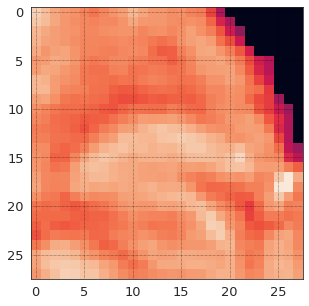

In [85]:
plt.imshow(patch_dataset[0][26].squeeze())

In [49]:
brats_X_train_axial = make_patch_dataset(train_fn, 28, 60000, 
                   tol=0, seed=2023, mask_paths=seg_train_fn, num_channels=1, bg_tol=None, plane='axial', flip_labels=True)
brats_X_val_axial = make_patch_dataset(val_fn, 28, 10000, 
                   tol=0, seed=2024, mask_paths=seg_train_fn, num_channels=1, bg_tol=None, plane='axial', flip_labels=True)
brats_X_val_axial_anom = make_patch_dataset(val_fn, 28, 10000, 
                   tol=0, seed=2025, mask_paths=seg_val_fn, num_channels=1, bg_tol=None, plane='axial', flip_labels=False)

100%|██████████| 28/28 [00:23<00:00,  1.18it/s]


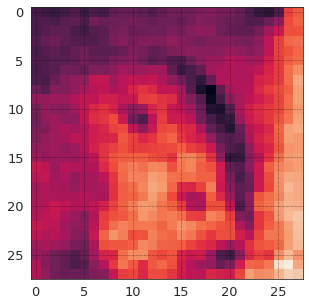

In [54]:
plt.imshow(brats_X_train_axial[50].squeeze())

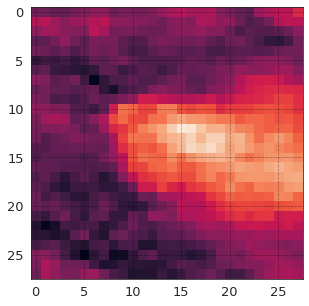

In [55]:
plt.imshow(brats_X_val_axial_anom[150].squeeze())

In [56]:
np.savez('/home/derek/mood_patches/brats_patches/brats_2018_train_fixed.npz', X_train=brats_X_train_axial, X_val=brats_X_val_axial)

In [34]:
y_toy = np.full((10000, 1), 1.)
np.savez('/home/derek/mood_patches/brats_patches/brats_2018_val_anom_new.npz', X_toy=brats_X_val_axial_anom, y_toy=y_toy )

### Brats Full Subvolumes

In [39]:
train_subvolume_dataset = []
for img_path, seg_path in zip(train_fn, seg_train_fn):
    img = nib.load(img_path).get_fdata()
    
    img = img / img.max()
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    print(img_path)
    
    subvolume = np.dstack([tf.image.central_crop(np.expand_dims(subvolume[:, :, s], -1), 224/subvolume.shape[0]).numpy() for s in range(4)])
    seg_subvolume = np.dstack([tf.image.central_crop(np.expand_dims(seg_subvolume[:, :, s], -1), 224/seg_subvolume.shape[0]).numpy() for s in range(4)])
    
    subvolume_pixels = subvolume.ravel()[seg_subvolume.ravel() == 0]
    subvolume_pixels = subvolume_pixels[subvolume_pixels > 0]
    kde = stats.gaussian_kde(subvolume_pixels)
    kde_sample = np.c_[[kde.resample((224, 224)) for _ in range(4)]].squeeze().reshape(224, 224, 4)
    #kde_sample = np.full(subvolume.shape, subvolume_pixels.mean())

    masked_img = np.expand_dims((subvolume * (seg_subvolume == 0)) + kde_sample * (seg_subvolume != 0), 0)
    train_subvolume_dataset.append(masked_img)
        
train_subvolume_np = np.concatenate(train_subvolume_dataset, 0)

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA13_624_1/Brats18_TCIA13_624_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQD_1/Brats18_CBICA_AQD_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_491_1/Brats18_TCIA02_491_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA08_113_1/Brats18_TCIA08_113_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_640_1/Brats18_TCIA10_640_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AVG_1/Brats18_CBICA_AVG_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_6_1/Brats18_2013_6_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ATV_1/Brats18_CBICA_ATV_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA06_409_1/Brats

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA09_620_1/Brats18_TCIA09_620_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA09_177_1/Brats18_TCIA09_177_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AOP_1/Brats18_CBICA_AOP_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA08_436_1/Brats18_TCIA08_436_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA03_338_1/Brats18_TCIA03_338_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_261_1/Brats18_TCIA10_261_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_449_1/Brats18_TCIA10_449_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_420_1/Brats18_TCIA10_420_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA08_205_1/Brats18_TCIA08_205_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA03

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQT_1/Brats18_CBICA_AQT_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA12_298_1/Brats18_TCIA12_298_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ASY_1/Brats18_CBICA_ASY_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_5_1/Brats18_2013_5_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_16_1/Brats18_2013_16_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_151_1/Brats18_TCIA02_151_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AXJ_1/Brats18_CBICA_AXJ_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA04_111_1/Brats18_TCIA04_111_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AUR_1/Brats18_CBICA_AUR_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_625_1/Brats18_TCIA1

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AXQ_1/Brats18_CBICA_AXQ_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ANI_1/Brats18_CBICA_ANI_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_BHK_1/Brats18_CBICA_BHK_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA08_105_1/Brats18_TCIA08_105_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_490_1/Brats18_TCIA10_490_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA08_162_1/Brats18_TCIA08_162_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_471_1/Brats18

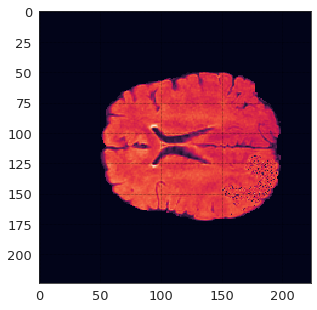

In [37]:
plt.imshow(train_subvolume_dataset[10][:, :, 3])

In [10]:
val_subvolume_dataset = []
for img_path, seg_path in zip(val_fn, seg_val_fn):
    img = nib.load(img_path).get_fdata()
    img = img / img.max()
    
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    print(img_path)
    subvolume = np.dstack([tf.image.central_crop(np.expand_dims(subvolume[:, :, s], -1), 224/subvolume.shape[0]).numpy() for s in range(4)])
    seg_subvolume = np.dstack([tf.image.central_crop(np.expand_dims(seg_subvolume[:, :, s], -1), 224/seg_subvolume.shape[0]).numpy() for s in range(4)])
    
    subvolume_pixels = subvolume.ravel()[seg_subvolume.ravel() == 0]
    subvolume_pixels = subvolume_pixels[subvolume_pixels > 0]
    kde = stats.gaussian_kde(subvolume_pixels)
    kde_sample = np.c_[[kde.resample((224, 224)) for _ in range(4)]].squeeze().reshape(224, 224, 4)
    #kde_sample = np.full(subvolume.shape, subvolume_pixels.mean())

    masked_img = np.expand_dims((subvolume * (seg_subvolume == 0)) + kde_sample * (seg_subvolume != 0), 0)
    val_subvolume_dataset.append(masked_img)
    
val_subvolume_np = np.concatenate(val_subvolume_dataset, 0)

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ASK_1/Brats18_CBICA_ASK_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQR_1/Brats18_CBICA_AQR_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_408_1/Brats18_TCIA10_408_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_190_1/Brats18_TCIA01_190_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AVJ_1/Brats18_CBICA_AVJ_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_9_1/Brats18_2013_9_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_413_1/Brats18_TCIA10_413_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ANP_1/Brats18_CB

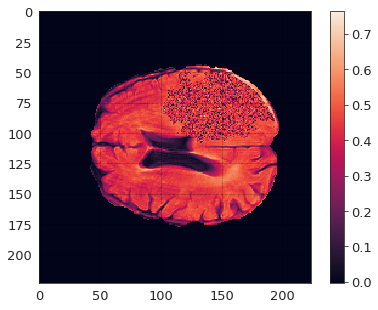

In [35]:
plt.imshow(val_subvolume_np[25, :, :, 2])
plt.colorbar()

In [47]:
val_anom_subvolume_dataset = []
for img_path, seg_path in zip(val_fn, seg_val_fn):
    img = nib.load(img_path).get_fdata()
    img = img / img.max()
    
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    subvolume = np.dstack([tf.image.central_crop(np.expand_dims(subvolume[:, :, s], -1), 224/subvolume.shape[0]).numpy() for s in range(4)])
    seg_subvolume = np.dstack([tf.image.central_crop(np.expand_dims(seg_subvolume[:, :, s], -1), 224/seg_subvolume.shape[0]).numpy() for s in range(4)])
    
    subvolume = np.expand_dims(subvolume, 0)
    
    print(img_path)
    
    # subvolume_pixels = subvolume.ravel()[seg_subvolume.ravel() == 0]
    # subvolume_pixels = subvolume_pixels[subvolume_pixels > 0]
    # kde = stats.gaussian_kde(subvolume_pixels)
    # kde_sample = np.c_[[kde.resample((224, 224)) for _ in range(4)]].squeeze().reshape(224, 224, 4)

    val_anom_subvolume_dataset.append(subvolume)
            
val_anom_subvolume_np = np.concatenate(val_anom_subvolume_dataset, 0)

/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQP_1/Brats18_CBICA_AQP_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AXN_1/Brats18_CBICA_AXN_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ASK_1/Brats18_CBICA_ASK_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AQR_1/Brats18_CBICA_AQR_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_408_1/Brats18_TCIA10_408_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_190_1/Brats18_TCIA01_190_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_AVJ_1/Brats18_CBICA_AVJ_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_9_1/Brats18_2013_9_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/LGG/Brats18_TCIA10_413_1/Brats18_TCIA10_413_1_flair.nii
/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ANP_1/Brats18_CB

In [75]:
np.savez(
    '/home/derek/mood_patches/brats_patches/brats_train_full_subvolume_lin_norm.npz',
    X_train=train_subvolume_np,
    X_val=val_subvolume_np
)

y_toy = np.full((val_anom_subvolume_np.shape[0], 1), 1.)
np.savez(
    '/home/derek/mood_patches/brats_patches/brats_anom_full_subvolume_lin_norm.npz',
    X_toy=val_anom_subvolume_np,
    y_toy=y_toy
)

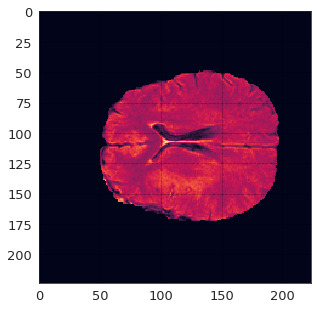

In [68]:
plt.imshow(val_anom_subvolume_np[11, :, :, 1])

### BraTS Normalized + Registered Half Brain Slices

In [6]:
# Extracting file names from training folder
dirname = '/data/BraTS2018/BraTS18_Training_norm/'
seg_dirname = '/data/BraTS2018/BraTS18_Training_norm/'
brats_2018_paths = sorted(get_nifti(dirname, key_words={'flair_Warped'}))
brats_2018_seg_paths = sorted(get_nifti(seg_dirname, key_words={'seg'}), key=lambda f: f.split('/')[-1])

random.seed(11)
path_pairs = list(zip(brats_2018_paths, brats_2018_seg_paths))
segs = [seg for _, seg in path_pairs]
imgs = [train for train, _ in path_pairs]

train_size = int(len(imgs) - np.ceil(0.1 * len(imgs)))

train_fn = imgs[:train_size]
seg_train_fn = segs[:train_size]
val_fn = imgs[train_size:]
seg_val_fn = segs[train_size:]

In [7]:
len(brats_2018_paths)

285

In [58]:
np.unique(seg_subvolume)

array([0.        , 0.00052472, 0.00672412, 0.01228184, 0.01312472,
       0.01475315, 0.01477612, 0.02523364, 0.02848572, 0.03080076,
       0.03658429, 0.03975843, 0.07025886, 0.07064554, 0.10302286,
       0.10388749, 0.11464835, 0.11497774, 0.11772831, 0.12546104,
       0.12682082, 0.13544678, 0.13638763, 0.1372455 , 0.14108496,
       0.15291727, 0.15820043, 0.16275132, 0.16601244, 0.16739085,
       0.17404492, 0.19297319, 0.20046278, 0.20165014, 0.2085876 ,
       0.23325536, 0.23762117, 0.26483783, 0.27179806, 0.2749001 ,
       0.28323593, 0.2873451 , 0.30569696, 0.35446395, 0.37056303,
       0.38464308, 0.38737119, 0.40984145, 0.46786932, 0.47750267,
       0.51102353, 0.51649954, 0.52365146, 0.54067079, 0.54937142,
       0.55267653, 0.56389677, 0.56857964, 0.57716717, 0.60980799,
       0.62307708, 0.62383102, 0.67262041, 0.68013641])

In [13]:
train_subvolume_dataset = []
img_size = 224
central_crop = torchvision.transforms.CenterCrop((img_size, img_size))
path_pairs = tqdm(zip(train_fn, seg_train_fn), total=len(train_fn), leave=True, position=0)
i = 0
for img_path, seg_path in path_pairs:
    img = nib.load(img_path).get_fdata()
    
    img = np.clip(img / 2, 0, 1)
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    # subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0).numpy() for s in range(4)])
    # seg_subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(seg_subvolume[:, :, s], -0))).permute(1, 2, 0).numpy() for s in range(4)])
    
    subvolume = [central_crop(torch.tensor(subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    seg_subvolume = [central_crop(torch.tensor(seg_subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    #seg_subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(seg_subvolume[:, :, s], 0))).permute(1, 2, 0).numpy() for s in range(4)])
    # print(f"Top: {seg_subvolume[:img_size // 2, :, :].sum()}, Bottom: {seg_subvolume[img_size // 2:, :, :].sum()}")
    
    subvolume = np.c_[subvolume]
    seg_subvolume = np.c_[seg_subvolume]
    
    for sli in range(3):
        if seg_subvolume[sli, :img_size // 2, :].sum() == 0:
            train_subvolume_dataset.append(subvolume[[sli], :img_size // 2, :, :])
        if seg_subvolume[sli, img_size // 2:, :].sum() == 0:
            flipped = subvolume[[sli], img_size // 2:, :, :][:, ::-1, :, :]
            train_subvolume_dataset.append(flipped)
        
train_subvolume_np = np.concatenate(train_subvolume_dataset)

100%|██████████| 256/256 [01:40<00:00,  2.55it/s]


In [73]:
train_subvolume_np.shape

(602, 112, 224, 1)

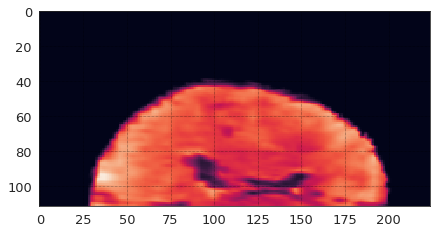

In [85]:
plt.imshow(train_subvolume_np[10].squeeze())

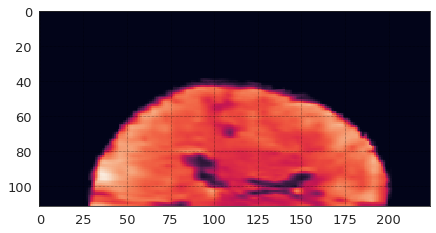

In [22]:
plt.imshow(train_subvolume_np[9].squeeze())

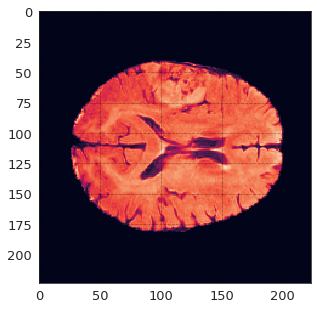

In [113]:
plt.imshow(subvolume[0].squeeze())

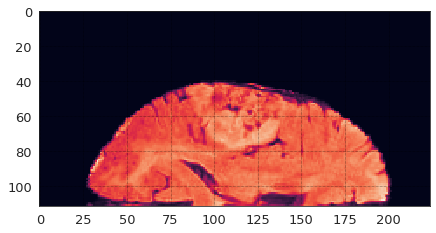

In [118]:
plt.imshow(subvolume[0][:img_size//2, :, 0])

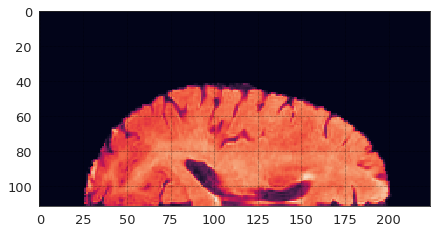

In [116]:
plt.imshow(np.flipud(subvolume[0][img_size//2:, :, 0]))

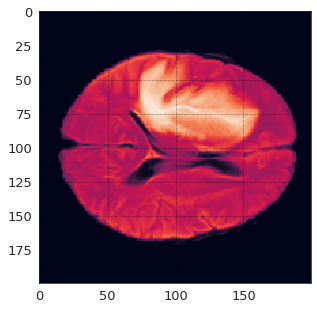

In [179]:
plt.imshow(subvolume[:, :, 3])

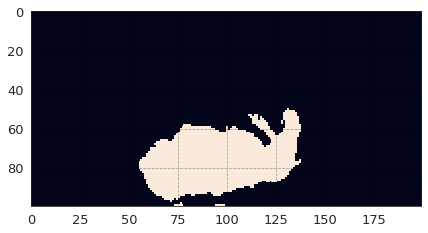

In [180]:
plt.imshow(seg_subvolume[:img_size//2, :, 0])

In [14]:
val_subvolume_dataset = []
cur_img = 0
img_size = 224
central_crop = torchvision.transforms.CenterCrop((img_size, img_size))
for img_path, seg_path in zip(val_fn[cur_img:], seg_val_fn[cur_img:]):
    img = nib.load(img_path).get_fdata()
    
    img = np.clip(img / 2, 0, 1)
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    # subvolume = np.dstack([tf.image.central_crop(np.expand_dims(subvolume[:, :, s], -1), 160/subvolume.shape[0]).numpy() for s in range(4)])
    # seg_subvolume = np.dstack([tf.image.central_crop(np.expand_dims(seg_subvolume[:, :, s], -1), 160/seg_subvolume.shape[0]).numpy() for s in range(4)])
    
    subvolume = [central_crop(torch.tensor(subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    #subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0).numpy() for s in range(4)])
    seg_subvolume = [central_crop(torch.tensor(seg_subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    #seg_subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(seg_subvolume[:, :, s], -0))).permute(1, 2, 0).numpy() for s in range(4)])
    #print(f"Top: {seg_subvolume[:img_size // 2, :, :].sum()}, Bottom: {seg_subvolume[img_size // 2:, :, :].sum()}")
    
    subvolume = np.c_[subvolume]
    seg_subvolume = np.c_[seg_subvolume]
    #print(subvolume.shape)
    
    
    for sli in range(3):
        if seg_subvolume[sli, :img_size // 2, :].sum() == 0:
            val_subvolume_dataset.append(subvolume[[sli], :img_size // 2, :, :])
        if seg_subvolume[sli, img_size // 2:, :].sum() == 0:
            flipped = subvolume[[sli], img_size // 2:, :, :][:, ::-1, :, :]
            val_subvolume_dataset.append(flipped)
        
val_subvolume_np = np.concatenate(val_subvolume_dataset, 0)
print(val_subvolume_np.shape)

(61, 112, 224, 1)


In [15]:
val_anom_subvolume_dataset = []
cur_img = 0
img_size = 224
central_crop = torchvision.transforms.CenterCrop((img_size, img_size))
for img_path, seg_path in zip(val_fn + train_fn, seg_val_fn + seg_train_fn):
    img = nib.load(img_path).get_fdata()
    
    img = np.clip(img / 2, 0, 1)
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    #subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0).numpy() for s in range(4)])
    
    subvolume = [central_crop(torch.tensor(subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    seg_subvolume = [central_crop(torch.tensor(seg_subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    
    subvolume = np.c_[subvolume]
    seg_subvolume = np.c_[seg_subvolume]
    
    for sli in range(3):
        if seg_subvolume[sli, :img_size // 2, :].sum() != 0:
            val_anom_subvolume_dataset.append(subvolume[[sli], :img_size // 2, :, :])
        if seg_subvolume[sli, img_size // 2:, :].sum() != 0:
            flipped = subvolume[[sli], img_size // 2:, :, :][:, ::-1, :, :]
            val_anom_subvolume_dataset.append(flipped)
        
val_anom_subvolume_np = np.concatenate(val_anom_subvolume_dataset, 0)
print(val_anom_subvolume_np.shape)

(1047, 112, 224, 1)


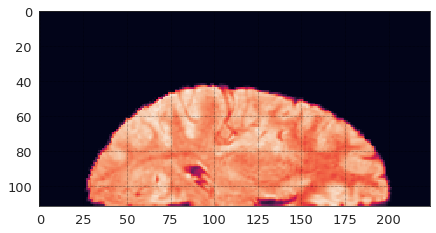

In [119]:
plt.imshow(val_subvolume_np[21].squeeze())

In [16]:
train_subvolume_np.shape

(602, 112, 224, 1)

In [17]:
val_anom_subvolume_np.shape

(1047, 112, 224, 1)

In [18]:
val_subvolume_np.shape

(61, 112, 224, 1)

In [19]:
np.savez(
    '/home/derek/mood_patches/brats_patches/brats_train_half_slices_reg_norm.npz',
    X_train=train_subvolume_np,
    X_val=val_subvolume_np
)

y_toy = np.full((val_anom_subvolume_np.shape[0], 1), 1.)
np.savez(
    '/home/derek/mood_patches/brats_patches/brats_anom_half_slices_reg_norm.npz',
    X_toy=val_anom_subvolume_np,
    y_toy=y_toy
)

### BraTS Normalized + Registered Half Brain Subvolumes

In [6]:
# Extracting file names from training folder
dirname = '/data/BraTS2018/BraTS18_Training_norm/'
seg_dirname = '/data/BraTS2018/BraTS18_Training_norm/'
brats_2018_paths = sorted(get_nifti(dirname, key_words={'flair_Warped'}))
brats_2018_seg_paths = sorted(get_nifti(seg_dirname, key_words={'seg'}), key=lambda f: f.split('/')[-1])

random.seed(11)
path_pairs = list(zip(brats_2018_paths, brats_2018_seg_paths))
segs = [seg for _, seg in path_pairs]
imgs = [train for train, _ in path_pairs]

train_size = int(len(imgs) - np.ceil(0.1 * len(imgs)))

train_fn = imgs[:train_size]
seg_train_fn = segs[:train_size]
val_fn = imgs[train_size:]
seg_val_fn = segs[train_size:]

In [7]:
len(brats_2018_paths)

285

In [7]:
train_subvolume_dataset = []
img_size = 224
central_crop = torchvision.transforms.CenterCrop((img_size, img_size))
path_pairs = tqdm(zip(train_fn, seg_train_fn), total=len(train_fn), leave=True, position=0)
i = 0
for img_path, seg_path in path_pairs:
    img = nib.load(img_path).get_fdata()
    
    #img = np.clip(img / 2, 0, 1)
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    # subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0).numpy() for s in range(4)])
    # seg_subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(seg_subvolume[:, :, s], -0))).permute(1, 2, 0).numpy() for s in range(4)])
    
    subvolume = [central_crop(torch.tensor(subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    seg_subvolume = [central_crop(torch.tensor(seg_subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    #seg_subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(seg_subvolume[:, :, s], 0))).permute(1, 2, 0).numpy() for s in range(4)])
    # print(f"Top: {seg_subvolume[:img_size // 2, :, :].sum()}, Bottom: {seg_subvolume[img_size // 2:, :, :].sum()}")
    
    subvolume = np.c_[subvolume]
    seg_subvolume = np.c_[seg_subvolume]
    
    if seg_subvolume[:, :img_size // 2, :].sum() == 0:
        train_subvolume_dataset.append(subvolume[:, :img_size // 2, :, :])
    if seg_subvolume[:, img_size // 2:, :].sum() == 0:
        flipped = subvolume[:, img_size // 2:, :, :][:, ::-1, :, :]
        train_subvolume_dataset.append(flipped)
        
train_subvolume_np = np.concatenate(train_subvolume_dataset)

100%|██████████| 256/256 [01:36<00:00,  2.66it/s]


In [73]:
train_subvolume_np.shape

(602, 112, 224, 1)

In [8]:
val_subvolume_dataset = []
cur_img = 0
img_size = 224
central_crop = torchvision.transforms.CenterCrop((img_size, img_size))
for img_path, seg_path in zip(val_fn[cur_img:], seg_val_fn[cur_img:]):
    img = nib.load(img_path).get_fdata()
    
    #img = np.clip(img / 2, 0, 1)
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    # subvolume = np.dstack([tf.image.central_crop(np.expand_dims(subvolume[:, :, s], -1), 160/subvolume.shape[0]).numpy() for s in range(4)])
    # seg_subvolume = np.dstack([tf.image.central_crop(np.expand_dims(seg_subvolume[:, :, s], -1), 160/seg_subvolume.shape[0]).numpy() for s in range(4)])
    
    subvolume = [central_crop(torch.tensor(subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    #subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0).numpy() for s in range(4)])
    seg_subvolume = [central_crop(torch.tensor(seg_subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    #seg_subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(seg_subvolume[:, :, s], -0))).permute(1, 2, 0).numpy() for s in range(4)])
    #print(f"Top: {seg_subvolume[:img_size // 2, :, :].sum()}, Bottom: {seg_subvolume[img_size // 2:, :, :].sum()}")
    
    subvolume = np.c_[subvolume]
    seg_subvolume = np.c_[seg_subvolume]
    #print(subvolume.shape)
    
    
    if seg_subvolume[:, :img_size // 2, :].sum() == 0:
        val_subvolume_dataset.append(subvolume[:, :img_size // 2, :, :])
    if seg_subvolume[:, img_size // 2:, :].sum() == 0:
        flipped = subvolume[:, img_size // 2:, :, :][:, ::-1, :, :]
        val_subvolume_dataset.append(flipped)
        
val_subvolume_np = np.concatenate(val_subvolume_dataset, 0)
print(val_subvolume_np.shape)

(76, 112, 224, 1)


In [9]:
val_anom_subvolume_dataset = []
cur_img = 0
img_size = 224
central_crop = torchvision.transforms.CenterCrop((img_size, img_size))
for img_path, seg_path in zip(val_fn + train_fn, seg_val_fn + seg_train_fn):
    img = nib.load(img_path).get_fdata()
    
    # img = np.clip(img / 2, 0, 1)
    seg = nib.load(seg_path).get_fdata()
    subvolume = img[:, :, 89:93]
    seg_subvolume = seg[:, :, 89:93]
    
    #subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0).numpy() for s in range(4)])
    
    subvolume = [central_crop(torch.tensor(subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    seg_subvolume = [central_crop(torch.tensor(seg_subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    
    subvolume = np.c_[subvolume]
    seg_subvolume = np.c_[seg_subvolume]
    
    if seg_subvolume[:, :img_size // 2, :].sum() != 0:
        val_anom_subvolume_dataset.append(subvolume[:, :img_size // 2, :, :])
    if seg_subvolume[:, img_size // 2:, :].sum() != 0:
        flipped = subvolume[:, img_size // 2:, :, :][:, ::-1, :, :]
        val_anom_subvolume_dataset.append(flipped)
        
val_anom_subvolume_np = np.concatenate(val_anom_subvolume_dataset, 0)
print(val_anom_subvolume_np.shape)

(1436, 112, 224, 1)


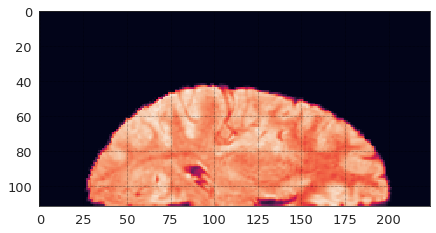

In [119]:
plt.imshow(val_subvolume_np[21].squeeze())

In [16]:
train_subvolume_np.shape

(602, 112, 224, 1)

In [17]:
val_anom_subvolume_np.shape

(1047, 112, 224, 1)

In [18]:
val_subvolume_np.shape

(61, 112, 224, 1)

In [10]:
np.savez(
    '/home/derek/mood_patches/brats_patches/brats_train_half_subvolume_no_scale.npz',
    X_train=train_subvolume_np,
    X_val=val_subvolume_np
)

y_toy = np.full((val_anom_subvolume_np.shape[0], 1), 1.)
np.savez(
    '/home/derek/mood_patches/brats_patches/brats_anom_half_subvolume_no_scale.npz',
    X_toy=val_anom_subvolume_np,
    y_toy=y_toy
)

### Brats Registered Slices

In [84]:
# Extracting file names from training folder
dirname = '/data/BraTS2018/BraTS18_Training_norm/'
seg_dirname = '/data/BraTS2018/BraTS18_Training_norm/'
brats_2018_paths = sorted(get_nifti(dirname, key_words={'flair_Warped'}))
brats_2018_seg_paths = sorted(get_nifti(seg_dirname, key_words={'seg'}), key=lambda f: f.split('/')[-1])

random.seed(11)
path_pairs = list(zip(brats_2018_paths, brats_2018_seg_paths))
segs = [seg for _, seg in path_pairs]
imgs = [train for train, _ in path_pairs]

train_size = int(len(imgs) - np.ceil(0.1 * len(imgs)))

train_fn = imgs[:train_size]
seg_train_fn = segs[:train_size]
val_fn = imgs[train_size:]
seg_val_fn = segs[train_size:]

In [85]:
train_slices_dataset = []
img_size = 224
central_crop = torchvision.transforms.CenterCrop((img_size, img_size))
path_pairs = tqdm(zip(train_fn, seg_train_fn), total=len(train_fn), leave=True, position=0)
for img_path, seg_path in path_pairs:
    img = nib.load(img_path).get_fdata()
    
    img = img / 2
    seg = nib.load(seg_path).get_fdata()
    
    # subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0).numpy() for s in range(4)])
    # seg_subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(seg_subvolume[:, :, s], -0))).permute(1, 2, 0).numpy() for s in range(4)])
    
    # subvolume = [central_crop(torch.tensor(subvolume[:, :, s]).unsqueeze(0)).permute(1, 2, 0).numpy() for s in range(4)]
    # seg_subvolume = np.dstack([central_crop(torch.tensor(np.expand_dims(seg_subvolume[:, :, s], -0))).permute(1, 2, 0).numpy() for s in range(4)])
    # print(f"Top: {seg_subvolume[:img_size // 2, :, :].sum()}, Bottom: {seg_subvolume[img_size // 2:, :, :].sum()}")
    
    for sli in range(88, 93):
        if seg[:, :, sli].sum() == 0:
            train_slices_dataset.append(central_crop(torch.tensor(img[:, :, sli])).numpy())

train_slices_np = np.concatenate(train_slices_dataset, 0)

100%|██████████| 256/256 [01:34<00:00,  2.71it/s]


In [31]:
len(train_slices_dataset)

124

In [24]:
4 * 256 * 224 * 224

51380224

In [21]:
28 * 28 * 60000

47040000

### Testing the Intensity Distributions of The Norm Brains

216979.94357049445


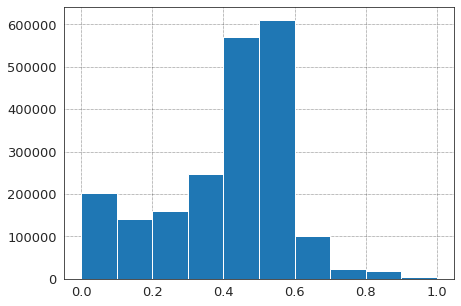

In [83]:
ind = 19
img = nib.load(train_fn[ind]).get_fdata()
img /= 2
img = np.clip(img, 0, 1)

plt.hist(img.ravel()[img.ravel() != 0])
print(nib.load(seg_train_fn[ind]).get_fdata().sum())

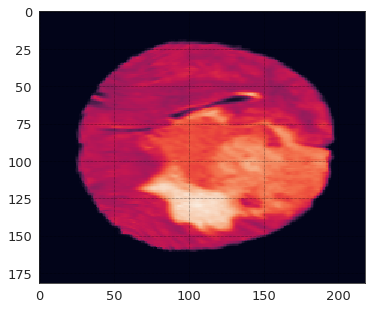

In [73]:
plt.imshow(img[:, :, 93])

In [59]:
img.mean()

0.12131713275594469